In [1]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   new_RandomForest.ipynb
@Time    :   2022/03/25 12:11:54
@Author  :   Pan Yifan
@Version :   1.0
@Desc    :   None
1. 
'''



'\n@File    :   new_RandomForest.ipynb\n@Time    :   2022/03/25 12:11:54\n@Author  :   Pan Yifan\n@Version :   1.0\n@Desc    :   None\n1. \n'

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from ta.momentum import *
from ta.volume import *
from ta.trend import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
from prettytable import PrettyTable
from sklearn.metrics import precision_recall_fscore_support
import joblib
from features_building import *
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [4]:
crt_path = '\\'.join(os.getcwd().split('\\')[:-1])
data_name = '三个股指.xlsx'
SP500_name = 'S&P 500'
Nasdaq_name = 'NASDAQ 100'
DJ_name = 'DOW JONES'
data_path = crt_path + '\\Data\\' + data_name


In [5]:
SP500_data = pd.read_excel(data_path, index_col=[0], sheet_name=SP500_name)
Nasdaq_data = pd.read_excel(data_path, index_col=[0], sheet_name=Nasdaq_name)
DJ_data = pd.read_excel(data_path, index_col=[0], sheet_name=DJ_name)


def process_data(data):
    data.index = pd.to_datetime(data.index, format='%Y%m%d')
    data = data.rename(columns={'HIGH': 'High', 'CLOSE': 'Close', 'OPEN': 'Open', 'LOW': 'Low', 'VOLUME': 'Tick volume'})
    data = data.sort_index(ascending=True).dropna(how='any')
    data['Change'] = data['Close'] - data['Close'].shift(1)
    data['Change'][data['Change'] <= 0] = 0
    data['Change'][data['Change'] > 0] = 1
    data['Down'] = -data['Change'] + 1
    data['Percent'] = 100 * (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    data['Percent'] = data['Percent'].replace(0, 0.01)
    return data


SP500_data = process_data(SP500_data)
Nasdaq_data = process_data(Nasdaq_data)
DJ_data = process_data(DJ_data)
# print(SP500_data.shape)
# print(Nasdaq_data.shape)
# print(DJ_data.shape)

C:\Users\19990\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\19990\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\19990\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Features Building

In [6]:
def generate_feature(data, index):
    feature_choices = list(range(0, 100, 1))  #!
    try:
        remove_list = []  #!
        for i in remove_list:
            feature_choices.remove(i)
    except:
        feature_choices = feature_choices
    # feature_choices = [6]  #!
    feature_pool = []
    for feature_choice in feature_choices:
        if not isinstance(feature_building().cal_feature(data, feature_choice), pd.Series):
            continue
        feature_pool.append(feature_building().cal_feature(data, feature_choice).rename(index + '_' + str(feature_choice)))
    features = pd.concat(feature_pool, axis=1)
    features = (features - features.min()) / (features.max() - features.min())
    # features['Change11'] = data['Change'].shift(1)
    return features


SP500_feature = generate_feature(SP500_data, 'SP500').replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
Nasdaq_feature = generate_feature(Nasdaq_data, 'Nasdaq').replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
DJ_feature = generate_feature(DJ_data, 'DJ').replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
features = pd.concat([SP500_feature, Nasdaq_feature, DJ_feature], axis=1).dropna(how='all', axis=1).dropna(how='any', axis=0)
print(features.shape)

C:\Users\19990\AppData\Roaming\Python\Python37\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\19990\AppData\Roaming\Python\Python37\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


(2539, 144)


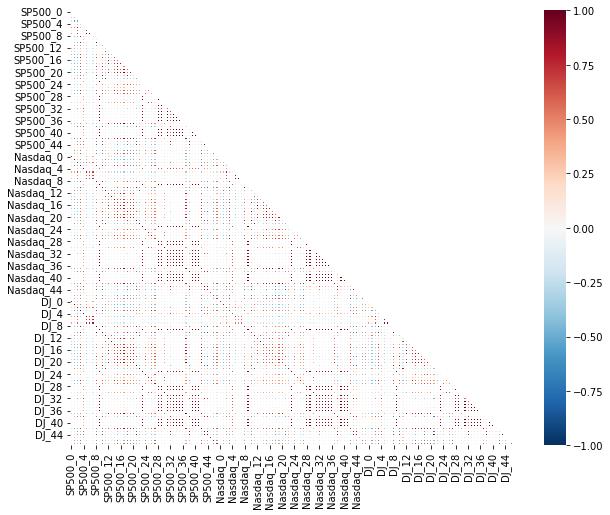

In [7]:
if len(features.iloc[0]) > 5:
    # print(features.iloc[30:].corr())
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_corr = features.corr()
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))
    sns.heatmap(feature_corr, cmap="RdBu_r", linewidth=0.1, mask=mask, vmax=1, vmin=-1)
    plt.show()
    plt.close()


In [8]:
feature_temp = features.copy()
feature_temp[-1] = 1
print(variance_inflation_factor(feature_temp.values, 1))


55.25217244686992


Backtest Parameters

In [9]:
start_date = '2012.03.09'  #!
end_date = '2022.01.21'
start_date = datetime.datetime.strptime(start_date, '%Y.%m.%d')
end_date = datetime.datetime.strptime(end_date, '%Y.%m.%d')
features = features.loc[start_date:end_date]
print(features.shape)

(2485, 144)


PreProcessing

In [10]:
def selection_kbest(features):
    fs = SelectKBest(f_classif, k=int(features.shape[1] * 0.9) + 1)
    features = fs.fit_transform(np.array(features), np.array(SP500_data.loc[start_date:end_date]['Change']))
    features = pd.DataFrame(features)
    print(features.shape)
    return features


# features = selection_kbest(features)


Correlation

In [11]:
feature_temp = features.copy()
print(variance_inflation_factor(feature_temp.values, 1))

55.289784970779806


(2485, 29)


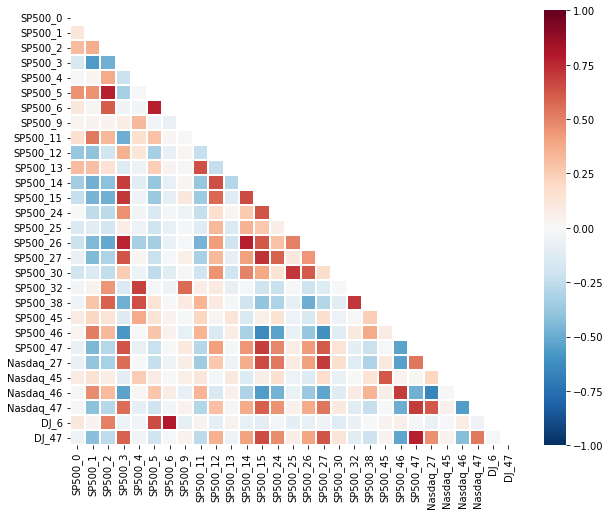

In [12]:
def selection_corr(features):
    if len(features.iloc[0]) > 5:
        feature_corr = features.corr()
        corr_std = 0.8  #!
        columns = np.full((feature_corr.shape[0], ), True, dtype=bool)
        for i in range(feature_corr.shape[0]):
            for j in range(i + 1, feature_corr.shape[0]):
                if abs(feature_corr.iloc[i, j]) > corr_std:
                    columns[j] = False
        selected_columns = features.columns[columns]
        features = features[selected_columns]
        print(features.shape)
        fig, ax = plt.subplots(figsize=(10, 8))
        feature_corr = features.iloc[30:].corr()
        mask = np.triu(np.ones_like(feature_corr, dtype=bool))
        sns.heatmap(feature_corr, cmap="RdBu_r", linewidth=0.3, mask=mask, vmax=1, vmin=-1)
        plt.show()
        plt.close()
    return features


features = selection_corr(features)


In [13]:
feature_index = features.index


PCA

In [14]:
feature_temp = features.copy()
print(variance_inflation_factor(feature_temp.values, 1))

22.5641270398746


In [15]:
def selection_pca(features):
    if len(features.iloc[0]) > 5 and variance_inflation_factor(features.iloc[50:].values, 1) > 5:
        pca = PCA(n_components='mle')
        features = pd.DataFrame(pca.fit_transform(features))
        features = (features - features.min()) / (features.max() - features.min())
        mask = np.triu(np.ones_like(features.corr(), dtype=bool))
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(features.corr(), cmap="RdBu_r", linewidth=0.3, mask=mask, vmax=1, vmin=-1)
        plt.show()
        plt.close()
    return features


# features = selection_pca(features)


In [16]:
features = features.reset_index(drop=True)

News Feature

In [17]:
news_name = 'textblob_result.xlsx'
news_path = crt_path + '\\Data\\' + news_name

In [18]:
news_data = pd.read_excel(news_path, index_col=[0])
news_data.index = pd.to_datetime(news_data.index, format='%Y-%m-%d')
news_data['polarity'] = news_data['polarity'].shift(1)


In [19]:
features.index = feature_index
features = pd.concat([features, news_data['polarity']], axis=1)
features = features.dropna(how='any')
print(features.shape)


(2485, 30)


Polynomial

In [20]:
def selection_poly(features, degree):
    poly = PolynomialFeatures(degree=degree, interaction_only=False)
    features = pd.DataFrame(poly.fit_transform(features), index=SP500_data.loc[start_date:end_date].index).iloc[:, 1:]
    return features


features_test = selection_poly(features, 2)
print(features_test.shape)

(2485, 495)


In [21]:
features = pd.concat([features, SP500_data['Percent'], Nasdaq_data['Percent'], DJ_data['Percent']], axis=1).dropna(how='any')
print(features.shape)

(2485, 33)


In [22]:
feature_index = features.index

In [23]:
test_size = 0.3
# X = (features.iloc[:, :-1] - features.iloc[:, :-1].min()) / (features.iloc[:, :-1].max() - features.iloc[:, :-1].min())
X = features.iloc[:, :-3]
Y = features.iloc[:, -3:]
X_train = np.array(X.iloc[:int(len(features) * (1 - test_size))])
Y_train = np.array(Y.iloc[:int(len(features) * (1 - test_size))])
X_test = np.array(X.iloc[int(len(features) * (1 - test_size)):])
Y_test = np.array(Y.iloc[int(len(features) * (1 - test_size)):])

In [24]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def print_report(report):
    table = PrettyTable(float_format="1.5f")
    table.field_names = ["Tag", "Precision", "Recall", "FBeta"]
    for i in range(2):
        tag, scores = [i], list(map(lambda metric: metric[i], report))[:-1]  # exclude support metric
        tag.extend(scores)
        table.add_row(tag)
    print(table)

In [25]:
parameters = [{
    'ccp_alpha': np.arange(1, 10) / 1000,
    'n_estimators': np.arange(8, 12) * 100,
}]
print(parameters[0])

{'ccp_alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]), 'n_estimators': array([ 800,  900, 1000, 1100])}


In [26]:
def my_gridsearch(parameters, X_train, Y_train):
    model = RandomForestRegressor()
    model = GridSearchCV(model, parameters, cv=3, n_jobs=12, verbose=3)
    model.fit(X_train, Y_train)
    best_parameters = model.best_estimator_.get_params()
    return best_parameters


best_parameters = {'n_estimators': 1000, 'max_depth': None, 'ccp_alpha': 0.005}

# best_parameters = my_gridsearch(parameters, X_train, np.array(Y_train[:, 0]))

for para, val in list(best_parameters.items()):
    print(para, val)


n_estimators 1000
max_depth None
ccp_alpha 0.005


S&P 500
{'MAE': 0.723528017732214, 'R2': 0.17327719011160003, 'MAPE': 2.126507964788262, 'MSE': 1.6617910671201443}


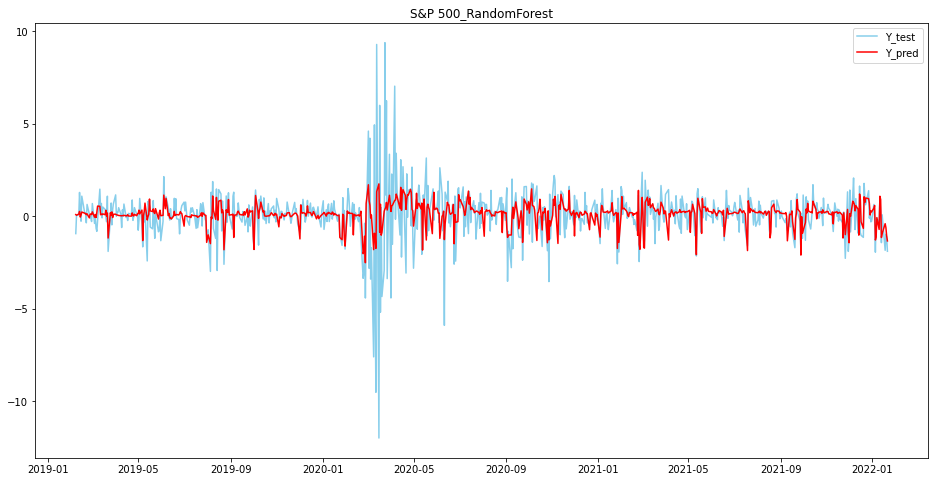

Nasdaq
{'MAE': 0.9405257675914466, 'R2': 0.13622332494505407, 'MAPE': 1.9550963719246428, 'MSE': 2.2192746464410984}


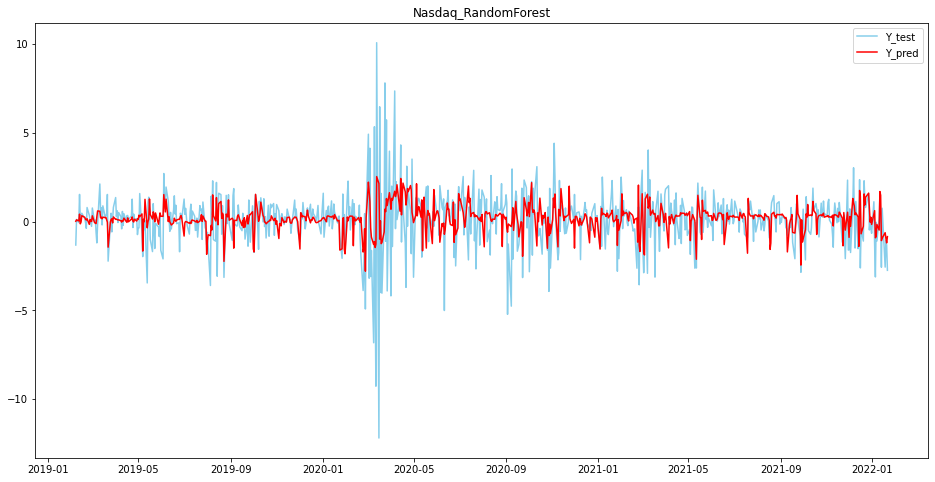

Dow Jones
{'MAE': 0.7430735199737272, 'R2': 0.15488788249147412, 'MAPE': 5.828022707927633, 'MSE': 1.8558523793779111}


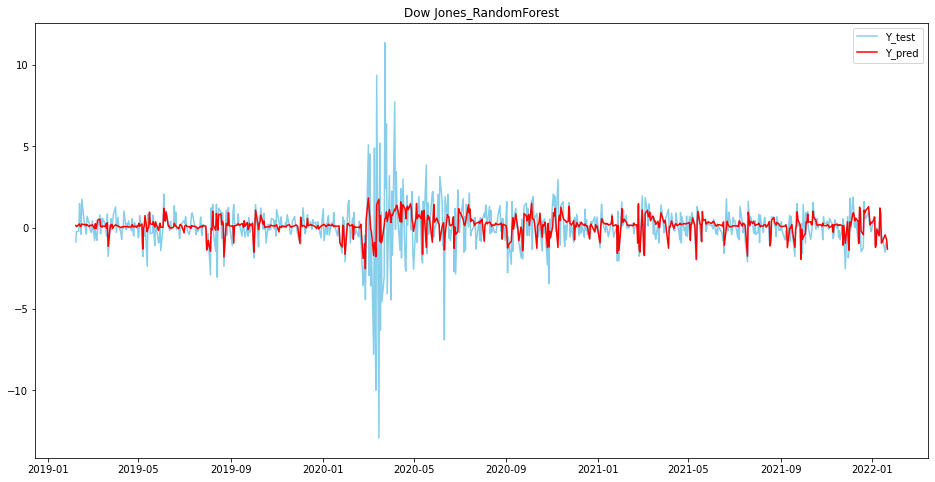

In [27]:
def my_train(best_parameters, X_test=X_test, Y_test=Y_test, X_train=X_train, Y_train=Y_train, crt_path=crt_path):
    save_switch = False
    save_switch = True  #!
    model_name = 'RandomForest'
    if save_switch:
        result_path = crt_path + '\\code\\models_{0}\\{0}_{1}'.format(model_name, now)
        create_folder(result_path)
        writer = pd.ExcelWriter(result_path + '\\{}_result.xlsx'.format(model_name))
    for i in range(3):
        if i == 0:
            index_name = 'S&P 500'
        elif i == 1:
            index_name = 'Nasdaq'
        elif i == 2:
            index_name = 'Dow Jones'
        print(index_name)
        model = RandomForestRegressor(**best_parameters, n_jobs=-1)
        steps = [
            # ('scalar', MinMaxScaler()),
            ('scalar', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, order='F')),
            ('pca', PCA(n_components='mle')),
            ('model', model),
        ]
        pipeline = Pipeline(steps)
        pipeline.fit(X_train, Y_train[:, i])
        # report = precision_recall_fscore_support(Y_test[:, i], model.predict(X_test), average=None, labels=[0, 1], zero_division=0)
        # print_report(report)
        Y_pred = pipeline.predict(X_test)
        metric_dict = {
            'MAE': mean_absolute_error(Y_test[:, i], Y_pred),
            'R2': r2_score(Y_test[:, i], Y_pred),
            'MAPE': mean_absolute_percentage_error(Y_test[:, i], Y_pred),
            'MSE': mean_squared_error(Y_test[:, i], Y_pred),
        }
        print(metric_dict)
        data_index = feature_index[int(len(features) * (1 - test_size)):]
        result = pd.DataFrame({'predict': Y_pred, 'real': Y_test[:, i]}, index=data_index)
        # print(result)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.plot(data_index, Y_test[:, i], label='Y_test', color='skyblue')
        ax.plot(data_index, Y_pred, label='Y_pred', color='red')
        ax.set_title(index_name + '_' + model_name)
        ax.legend()
        if save_switch:
            plt.savefig(result_path + '\\{}_{}_graph.jpeg'.format(model_name, index_name))
            with open(result_path + '\\{}_{}_parameters.txt'.format(model_name, index_name), 'w') as f:
                for para, val in list(best_parameters.items()):
                    f.write(str(para) + ' ' + str(val) + '\n')
            result.to_excel(writer, sheet_name='{}_result'.format(index_name))
            pd.DataFrame(metric_dict, index=[0]).to_excel(writer, sheet_name='{}_metric'.format(index_name))
            joblib.dump(model, result_path + '\\{}_{}_model.model'.format(model_name, index_name))
        plt.show()
        plt.close()
        # break
    if save_switch:
        writer.save()


my_train(best_parameters)
